# Handling Missing Data

This notebook contains the Python code for our session on how to handle missing data.  It uses an example data set of blood glucose, as read from a FreeStyle Libre blood glucose monitor.  This is real data!

We start using the usual Python suspects: Pandas, NumPy and matplotlib.

In [ ]:
!pip install fancyimpute

In [ ]:
# for other imputation methods
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
%matplotlib inline

# for KNN
from fancyimpute import KNN

Next we get a day's worth of insulin data.  Note that we reindexed this to use the minute of the day as the index.

/usr/local/lib/python3.10/dist-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


<Axes: xlabel='Minute_of_Day'>

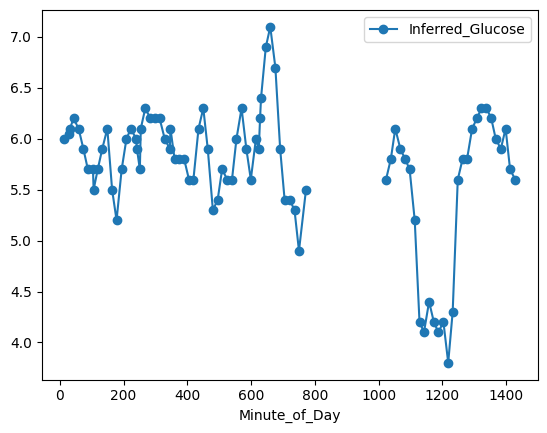

In [ ]:
df = pd.read_excel('/content/glucose.xlsx', index_col=0)
df.set_index('Minute_of_Day', inplace=True)
df.plot(style='o-')

Let's find the index entries of the missing data

In [ ]:
missing_minutes = list(df[df['Inferred_Glucose'].isnull()].index)
missing_minutes

[787,
 802,
 817,
 832,
 847,
 862,
 877,
 892,
 907,
 922,
 937,
 952,
 967,
 982,
 997,
 1012]

Convenience function for plotting

In [ ]:
def method_plot(df, cols):
    fig, ax = plt.subplots()
    if isinstance(cols, str):
        df[cols].plot(style='b--', ax=ax)
    else:
        for c in cols:
            df[c].plot(style='b--', ax=ax)
    df['Inferred_Glucose'].plot(style='bo', ax=ax)

# Last-Observed Carry Forward (LOCF)

So easy it's build into Pandas' fillna() as method='ffill'

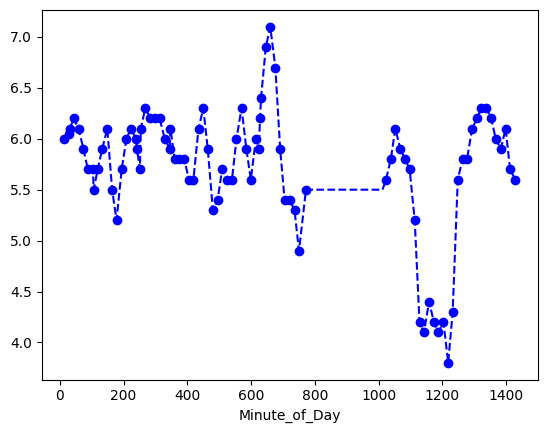

In [ ]:
df['Glucose_LOCF'] = df['Inferred_Glucose'].fillna(method='ffill')
method_plot(df, 'Glucose_LOCF')

# Mean value

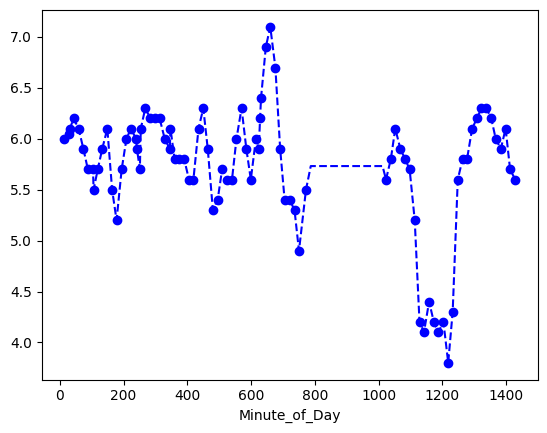

In [ ]:
df['Glucose_Mean'] = df['Inferred_Glucose'].fillna(df['Inferred_Glucose'].mean())
method_plot(df, 'Glucose_Mean')

#  Nearest Neighbor

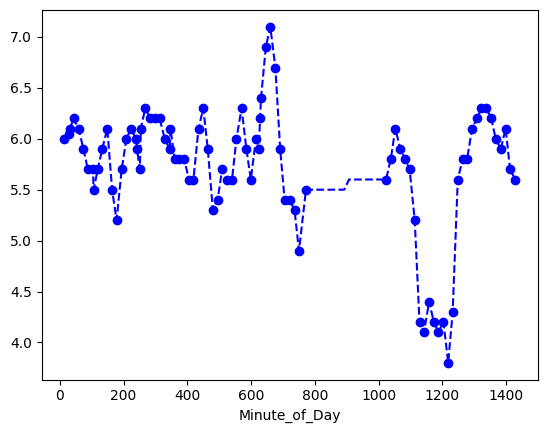

In [ ]:
df['Glucose_nearest_neighbor'] = df['Inferred_Glucose'].interpolate(method='nearest')
method_plot(df, 'Glucose_nearest_neighbor')

# Linear Interpolation

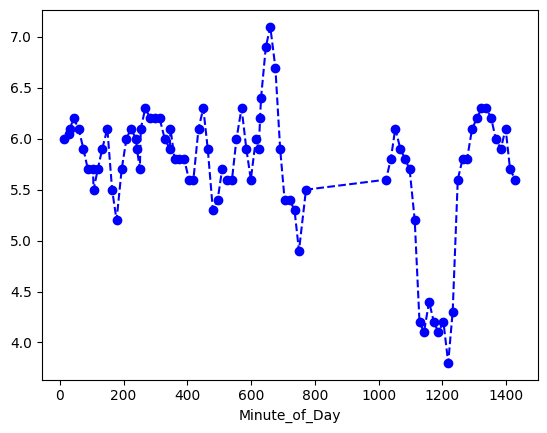

In [ ]:
df['Glucose_linear_interpolation'] = df['Inferred_Glucose'].interpolate(method='linear')
method_plot(df, 'Glucose_linear_interpolation')

# Polynomial Interpolation

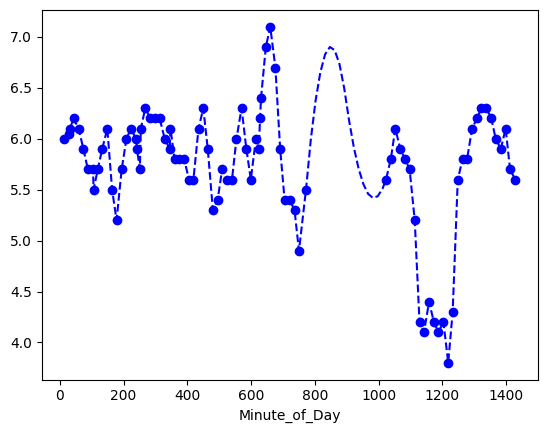

In [ ]:
df['Glucose_poly_interpolation_2'] = df['Inferred_Glucose'].interpolate(method='polynomial', order=2)
method_plot(df, 'Glucose_poly_interpolation_2')

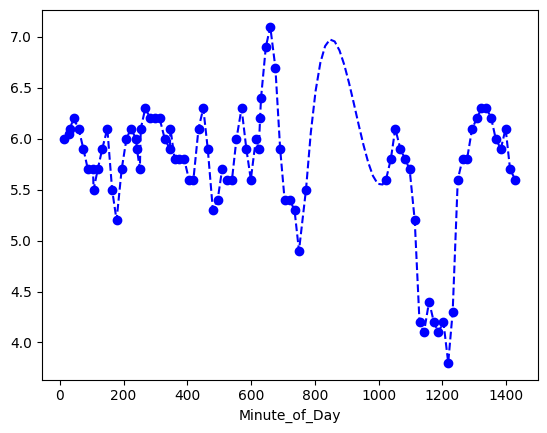

In [ ]:
df['Glucose_poly_interpolation_3'] = df['Inferred_Glucose'].interpolate(method='polynomial', order=3)
method_plot(df, 'Glucose_poly_interpolation_3')

# Spline Interpolation

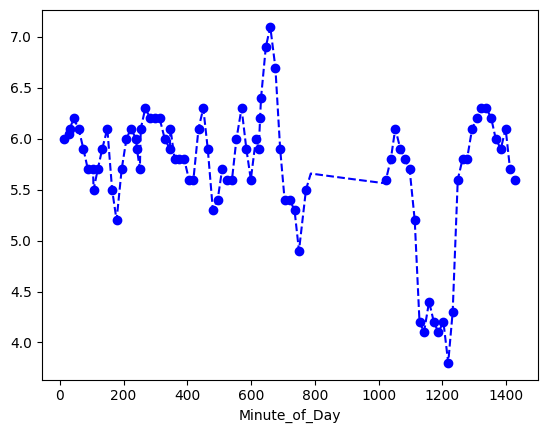

In [ ]:
df['Glucose_spline_2'] = df['Inferred_Glucose'].interpolate(method='spline', order=2)
method_plot(df, 'Glucose_spline_2')

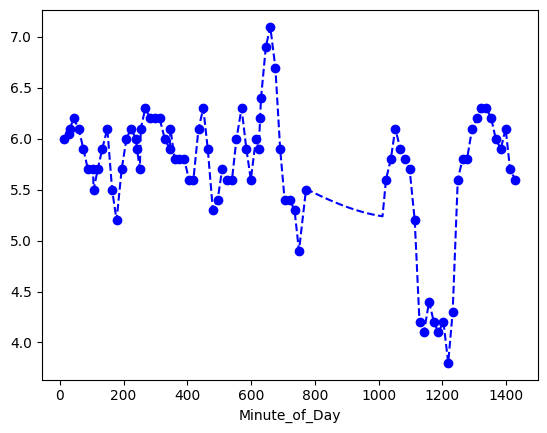

In [ ]:
df['Glucose_spline_3'] = df['Inferred_Glucose'].interpolate(method='spline', order=3)
method_plot(df, 'Glucose_spline_3')

# Moving Average Imputation

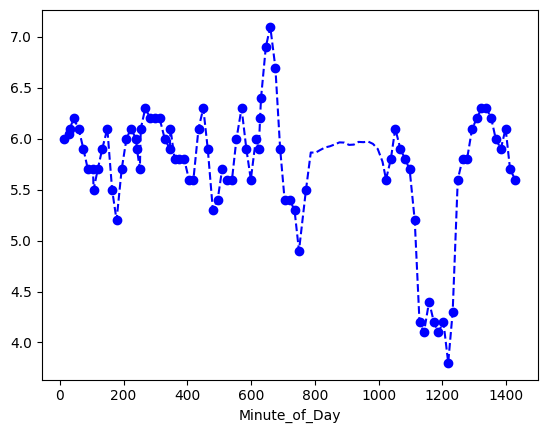

In [ ]:
df['Glucose_moving_average']=df.loc[:, ['Inferred_Glucose']].assign(RollingMean=df['Inferred_Glucose'].fillna(df['Inferred_Glucose'].rolling(24,min_periods=1,).mean()))['RollingMean']
method_plot(df, 'Glucose_moving_average')

# KNN imputation

Imputing row 1/102 with 0 missing, elapsed time: 0.006
Imputing row 101/102 with 0 missing, elapsed time: 0.008


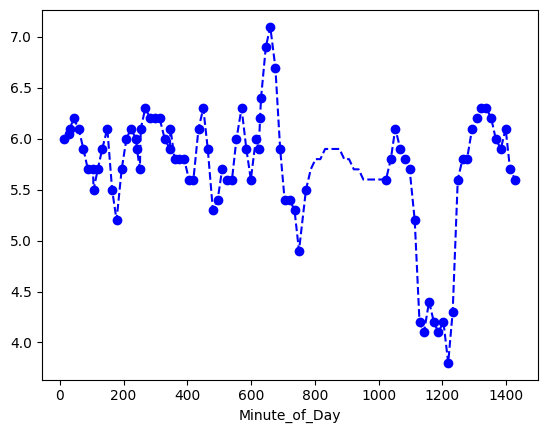

In [ ]:
knn_impute = KNN(k = 5).fit_transform(df)
df['Glucose_KNN']=knn_impute[:, 0]
method_plot(df, 'Glucose_KNN')

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import warnings # Supress warnings
warnings.filterwarnings('ignore')

def pred_with_ARIMA(imputation):
  print(imputation)
  # Load your data (replace this with your data loading code)
  # df = pd.read_csv('your_data.csv')

  # Define the window size for validation
  validation_window = 30  # You can adjust this value as needed

  # Iterate through the data with the validation window
  results = []  # To store MAE and MAPE for each iteration
  all_predictions = []  # To store all predictions for plotting

  for i in range(validation_window, len(df), validation_window):
      train_data = df[:i]
      test_data = df[i:i + validation_window]

      # Create and fit the ARIMA model
      model = ARIMA(train_data[imputation], order=(1, 1, 1))
      model_fit = model.fit()

      # Make predictions on the test data
      predictions = model_fit.forecast(steps=len(test_data[imputation]))
      all_predictions.extend(predictions)  # Store predictions for plotting

      # Calculate MAE and MAPE
      mae = mean_absolute_error(test_data[imputation], predictions)

      results.append((mae, mape))

      print(f"Window {i}-{i + validation_window - 1}")
      print("Mean Absolute Error (MAE):", mae)
      print("=" * 40)

  # Calculate and print the overall evaluation results
  mae_values = [result[0] for result in results]
  mape_values = [result[1] for result in results]

  final_mae = np.mean(mae_values)
  final_rmse = np.sqrt(mean_squared_error(df[imputation][validation_window:], all_predictions))

  print("Final Mean Absolute Error (MAE):", final_mae)
  print("Final Root Mean Squared Error (RMSE):", final_rmse)

  # Plot the MAE and MAPE over different validation windows
  plt.figure(figsize=(10, 6))
  plt.plot(range(validation_window, len(df), validation_window), mae_values, label='MAE')
  plt.plot(range(validation_window, len(df), validation_window), mape_values, label='MAPE')
  plt.axhline(y=final_mae, color='r', linestyle='--', label='Final MAE')
  plt.title('MAE and MAPE Over Validation Windows')
  plt.xlabel('Data Index')
  plt.ylabel('Error')
  plt.legend()
  plt.show()

  # Plot the predicted vs. actual values
  plt.figure(figsize=(10, 6))
  plt.plot(df.index, df[imputation], label='Actual')
  plt.plot(df.index[validation_window:], all_predictions, label='Predicted', color='red')
  plt.title(f'Actual vs. Predicted {imputation}')
  plt.xlabel('Minute of Day')
  plt.ylabel(imputation)
  plt.legend()
  plt.show()
  return final_mae

Glucose_LOCF = pred_with_ARIMA('Glucose_LOCF')
Glucose_Mean = pred_with_ARIMA('Glucose_Mean')
Glucose_nearest_neighbor = pred_with_ARIMA('Glucose_nearest_neighbor')
Glucose_linear_interpolation = pred_with_ARIMA('Glucose_linear_interpolation')
Glucose_poly_interpolation_2 = pred_with_ARIMA('Glucose_poly_interpolation_2')
Glucose_poly_interpolation_3 = pred_with_ARIMA('Glucose_poly_interpolation_3')
Glucose_spline_2 = pred_with_ARIMA('Glucose_spline_2')
Glucose_spline_3 = pred_with_ARIMA('Glucose_spline_3')
Glucose_moving_average = pred_with_ARIMA('Glucose_moving_average')
Glucose_KNN = pred_with_ARIMA('Glucose_KNN')


In [ ]:
MAE = [Glucose_LOCF, Glucose_Mean, Glucose_nearest_neighbor, Glucose_linear_interpolation, Glucose_poly_interpolation_2,
         Glucose_poly_interpolation_3, Glucose_spline_2, Glucose_spline_3, Glucose_moving_average, Glucose_KNN]
jenis_imput = ['Glucose_LOCF', 'Glucose_Mean', 'Glucose_nearest_neighbor', 'Glucose_linear_interpolation', 'Glucose_poly_interpolation_2',
         'Glucose_poly_interpolation_3', 'Glucose_spline_2', 'Glucose_spline_3', 'Glucose_moving_average', 'Glucose_KNN']
Hasil_Prediksi = pd.DataFrame({'Jenis Imputasi':jenis_imput, 'MAE':MAE}).sort_values(by='MAE')
Hasil_Prediksi

,Jenis Imputasi,MAE
3,Glucose_linear_interpolation,0.353372
2,Glucose_nearest_neighbor,0.357499
0,Glucose_LOCF,0.358473
1,Glucose_Mean,0.362216
6,Glucose_spline_2,0.365943
8,Glucose_moving_average,0.376902
7,Glucose_spline_3,0.378855
9,Glucose_KNN,0.389604
4,Glucose_poly_interpolation_2,0.562952
5,Glucose_poly_interpolation_3,0.566223


In [ ]:
print('MAE Glucose_LOCF', Glucose_LOCF)
print('MAE Glucose_Mean', Glucose_Mean)
print('MAE Glucose_nearest_neighbor', Glucose_nearest_neighbor)
print('MAE Glucose_linear_interpolation', Glucose_linear_interpolation)
print('MAE Glucose_poly_interpolation_2', Glucose_poly_interpolation_2)
print('MAE Glucose_poly_interpolation_3', Glucose_poly_interpolation_3)
print('MAE Glucose_spline_2', Glucose_spline_2)
print('MAE Glucose_spline_3', Glucose_spline_3)
print('MAE Glucose_moving_average', Glucose_moving_average)
print('MAE Glucose_KNN', Glucose_KNN)

MAE Glucose_LOCF 0.35847296665000017
MAE Glucose_Mean 0.3622156469061457
MAE Glucose_nearest_neighbor 0.35749934875450706
MAE Glucose_linear_interpolation 0.3533721953227688
MAE Glucose_poly_interpolation_2 0.5629523590914312
MAE Glucose_poly_interpolation_3 0.5662233094673801
MAE Glucose_spline_2 0.36594326837493174
MAE Glucose_spline_3 0.3788550226200699
MAE Glucose_moving_average 0.3769015257751573
MAE Glucose_KNN 0.38960423969778746
